# Data Cleaning and EDA

In this notebook we will go through the process of cleaning the raw data we have scraped from the two subreddits, 'iPhone' and 'Android'. The steps will include:

1. Data Imputation, removing duplicates
2. Data Cleaning: Removing html artifacts, stopwords, etc
3. Exploratory Data Analysis

In [1]:
#basic data imports

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [2]:
# NLP imports

import nltk
import regex as re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### 1.  Data Imputation

We will check for missing data, as well as handle duplicate posts.
There are also a lot of columns here, so we will be filtering out the unwanted ones.

In [3]:
iPhone_posts = pd.read_csv('datasets/iPhone-posts.csv')

In [4]:
iPhone_posts.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,num_crossposts,media,is_video,link_flair_template_id,url_overridden_by_dest,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday,poll_data
0,0,NaN,iphone,Welcome to the Daily Tech Support thread for /...,t2_6l4z3,False,NaN,0,False,Daily Tech Support Thread - [November 26],...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,iphone,I have hooked up a MagSafe charger in my car a...,t2_frdyc,False,NaN,0,False,How much power does MagSafe draw when there is...,...,0,NaN,False,5664e798-6985-11e8-b750-0eaf69e27a44,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,iphone,"Hi guys, if I was to buy a iphone second hand ...",t2_4r7upir5,False,NaN,0,False,Advice needed,...,0,NaN,False,5664e798-6985-11e8-b750-0eaf69e27a44,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,iphone,"Hello everyone, I have the iPhone 11 and until...",t2_1qd43scz,False,NaN,0,False,iPhone 11 iOS14,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,iphone,Proud owner of a new iPhone 11 Pro. First tim...,t2_4ikub,False,NaN,0,False,Super dumb question: iPhone 11 Pro owners. Do ...,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Check timeframe of postings**

We want to check when the first post and the last post of this data was recorded.

In [5]:
iPhone_posts['created_utc']

0       1.606363e+09
1       1.606353e+09
2       1.606351e+09
3       1.606348e+09
4       1.606348e+09
            ...     
1238    1.604797e+09
1239    1.604791e+09
1240    1.604788e+09
1241    1.604788e+09
1242    1.604789e+09
Name: created_utc, Length: 1243, dtype: float64

The time format here is in a [unix epoch time](https://en.wikipedia.org/wiki/Unix_time) format, which is not human readable. We will change it to a date-time format instead.

In [6]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(iPhone_posts['created_utc'][0]))

'2020-11-26 12:04:30'

In [7]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(iPhone_posts['created_utc'][940]))

'2020-10-22 02:24:37'

In [8]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(iPhone_posts['created_utc'][950]))

'2020-11-26 04:07:22'

**Timeframe of iPhone Posts**

Here we see some irregularity. The first posts was scraped on 26th of November, and the 940th post in our data was made on the 22nd of October. However, the 950th post was made on 26th of November.

This suggests that there wasn't enough posts in the subreddit and our webscraping code went back to the starting date (27th November) and started scraping again. This will result in a lot of duplicates, which we will remove later on.

In [9]:
iPhone_posts.shape

(1243, 114)

In [10]:
iPhone_posts['selftext'][1230:1235]

1230                                                  NaN
1231                                                  NaN
1232                                                  NaN
1233    I recently upgraded from the 11 pro to 12 pro....
1234    At first I liked the idea of an iPhone mini be...
Name: selftext, dtype: object

**Posts with empty text content**

We see that there are a lot of posts that do not have any textual content in the main body of the posts. These are mostly posts with just a title and a weblink to a video/image.

However, the text in the posts could still have value for analysis, so we combine the 'title' and the 'text' column before removing empty/duplicate posts

In [11]:
iPhone_posts['selftext'].replace(r'[^\w\s]', ' ', regex=True, inplace = True)

iPhone_posts['title'].replace(r'[^\w\s]', ' ', regex=True, inplace = True)

iPhone_posts.fillna(value = ' ', inplace = True)

In [12]:
iPhone_posts['title/text'] = iPhone_posts['selftext'] + ' ' + iPhone_posts['title']

iPhone_text = iPhone_posts[['author_fullname','title','selftext', 'title/text', 'subreddit']] 

iPhone_text

,author_fullname,title,selftext,title/text,subreddit
0,t2_6l4z3,Daily Tech Support Thread November 26,Welcome to the Daily Tech Support thread for ...,Welcome to the Daily Tech Support thread for ...,iphone
1,t2_frdyc,How much power does MagSafe draw when there is...,I have hooked up a MagSafe charger in my car a...,I have hooked up a MagSafe charger in my car a...,iphone
2,t2_4r7upir5,Advice needed,Hi guys if I was to buy a iphone second hand ...,Hi guys if I was to buy a iphone second hand ...,iphone
3,t2_1qd43scz,iPhone 11 iOS14,Hello everyone I have the iPhone 11 and until...,Hello everyone I have the iPhone 11 and until...,iphone
4,t2_4ikub,Super dumb question iPhone 11 Pro owners Do ...,Proud owner of a new iPhone 11 Pro First tim...,Proud owner of a new iPhone 11 Pro First tim...,iphone
...,...,...,...,...,...
1238,t2_14zgqe,Will a regular magnetic car vent mount work wi...,,Will a regular magnetic car vent mount work ...,iphone
1239,t2_jaz2j,Has anyone compared the night mode in the 11 p...,Just wondering,Just wondering Has anyone compared the night ...,iphone
1240,t2_n88ch,Question about the Magsafe wallet,I live in a country that doesn t support Apple...,I live in a country that doesn t support Apple...,iphone
1241,t2_cw7n8,3D Printed the MagSafe charger flush mount ada...,,3D Printed the MagSafe charger flush mount a...,iphone


In [13]:
iPhone_filtered = iPhone_text.drop_duplicates(subset = ['title/text'], keep = 'first')

iPhone_filtered = iPhone_filtered[['title/text', 'subreddit']]

iPhone_filtered.shape

(943, 2)

In [14]:
iPhone_filtered.isnull().sum()

title/text    0
subreddit     0
dtype: int64

**Enough data?**

After dropping duplicate posts, we have 943 posts remaining. This is expected from our earlier investigation into the time of posting. While a significant number of posts have been dropped, we still have 943 posts which is adequate for our analysis.

Next, we move on to do the same data cleaning process on the posts scrapped from the 'Android' subreddit.

In [15]:
Android_posts = pd.read_csv('datasets/Android-posts.csv')

Android_posts.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,author_cakeday
0,0,NaN,Android,NaN,t2_1unjxir5,False,NaN,0,False,Samsung trade in program is back again for Bal...,...,all_ads,False,https://www.samsung.com/lt/grazinimas/,2281500,1.606460e+09,0,NaN,False,NaN,NaN
1,1,NaN,Android,NaN,t2_56a46frx,False,NaN,0,False,Vivo unveils Origin Os - Will it be less polar...,...,all_ads,False,http://www.techradar.com/news/vivo-unveils-ori...,2281500,1.606457e+09,0,NaN,False,NaN,NaN
2,2,NaN,Android,NaN,t2_b8kyv,False,NaN,0,False,Nokia 2.4 hands-on - GSMArena,...,all_ads,False,https://www.gsmarena.com/nokia_24_handson-news...,2281500,1.606403e+09,0,NaN,False,NaN,NaN
3,3,NaN,Android,After recently acquiring a 1TB microSD card in...,t2_cqcpv2h,False,NaN,0,False,"Are high-speed/high-capacity (A1, A2, U3) micr...",...,all_ads,False,https://www.reddit.com/r/Android/comments/k1o0...,2281500,1.606427e+09,0,NaN,False,NaN,NaN
4,4,NaN,Android,NaN,t2_5l3x1fsc,False,NaN,0,False,Android App Bundles could have a drawback for ...,...,all_ads,False,https://www.slashgear.com/android-app-bundles-...,2281500,1.606380e+09,0,NaN,False,NaN,NaN


In [16]:
Android_posts.shape

(1225, 110)

In [17]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Android_posts['created_utc'][0]))

'2020-11-27 14:48:38'

In [18]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Android_posts['created_utc'][720]))

'2020-10-02 12:02:02'

In [19]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Android_posts['created_utc'][730]))

'2020-11-26 19:27:24'

**Timeframe of Android Posts**

Here we see a similar problem we faced with the iPhone postings. Many duplicate posts were removed because there wasn't enough posts stored in the subreddit. However, we still have 700+ posts which will be enough for our analysis.

In [20]:
Android_posts['selftext'].replace(r'[^\w\s]', ' ', regex=True, inplace = True)

Android_posts['title'].replace(r'[^\w\s]', ' ', regex=True, inplace = True)

Android_posts.fillna(value = ' ', inplace = True)

In [21]:
Android_posts['title/text'] = Android_posts['title'] + ' ' + Android_posts['selftext']

Android_text = Android_posts[['author_fullname','title','selftext', 'title/text', 'subreddit']] 

Android_text

,author_fullname,title,selftext,title/text,subreddit
0,t2_1unjxir5,Samsung trade in program is back again for Bal...,,Samsung trade in program is back again for Bal...,Android
1,t2_56a46frx,Vivo unveils Origin Os Will it be less polar...,,Vivo unveils Origin Os Will it be less polar...,Android
2,t2_b8kyv,Nokia 2 4 hands on GSMArena,,Nokia 2 4 hands on GSMArena,Android
3,t2_cqcpv2h,Are high speed high capacity A1 A2 U3 micr...,After recently acquiring a 1TB microSD card in...,Are high speed high capacity A1 A2 U3 micr...,Android
4,t2_5l3x1fsc,Android App Bundles could have a drawback for ...,,Android App Bundles could have a drawback for ...,Android
...,...,...,...,...,...
1220,t2_qlf0lq6,Google Assistant adds settings page to select ...,,Google Assistant adds settings page to select ...,Android
1221,t2_k75n8,OnePlus Buds Z launched at 3190 44,,OnePlus Buds Z launched at 3190 44,Android
1222,t2_5nm7hbhd,Is it me or the gap between iPhone and Android...,about hardware features I mean I used to hes...,Is it me or the gap between iPhone and Android...,Android
1223,t2_234mq3b6,I hate how Apple pulls moves like these and in...,1 Headphone jack gone Headphones are now wir...,I hate how Apple pulls moves like these and in...,Android


In [22]:
Android_filtered = Android_text.drop_duplicates(subset = ['title/text'], keep = 'first')

Android_filtered = Android_filtered[['title/text', 'subreddit']]

Android_filtered.shape

(725, 2)

## 2.  Data Cleaning

We now have two dataframes consisting of just the text from each post (including the title) as well as the subreddit to which the post belongs to.  
However, the text still consists of a lot of unwanted artifacts, as well as stopwords such as 'is', 'a', 'there', etc, which are not useful for analysis.

We will remove all these unwanted artifacts from our text data before carrying out our exploratory data analysis.

### 2.1  Setting of Stopwords

In [23]:
stops = set(stopwords.words('english'))
len(stops)

179

In [24]:
new_stops = {'iphone', 'iphones', 'android', 'phone', 
             'http', 'amp', 'www', 'com', 'thread', 'reddit', 'automoderator'}

# these additional stopwords were words that came up during our Exploratory analysis. 
# We add them here to make our data more accurate.

len(new_stops)

11

In [25]:
updated_stops = stops.union(new_stops)
len(updated_stops)

190

In [26]:
def review_to_words(raw_review, stoplist):
    
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    
    words = letters_only.lower().split()
    
    meaningful_words = [w for w in words if w not in stoplist]

    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in meaningful_words]

    return(" ".join(lemmas))

# this function carries out multiple operations on our data strings
# the output will be a string of text that will have non-words and stop words removed.
# we also lemmatize the words to improve the analysis process later on.

In [27]:
iPhone_filtered['title/text'][1]

'I have hooked up a MagSafe charger in my car and connected it to a third party USB C cigarette lighter plug\n\nEven with the engine turned off the cigarette lighter continues to deliver power to the MagSafe puck  \n\nI sometimes go a week or two without using my car  Would it be possible that the passive power draw of the MagSafe puck could run my car engine down  Or is the power draw so minimal that I have nothing g to worry about  How much power does MagSafe draw when there is no iPhone attached  Enough to flatten my car battery '

In [28]:
review_to_words(iPhone_filtered['title/text'][1], updated_stops)

# this is just to check if the text cleaning function we created works as expected.

'hooked magsafe charger car connected third party usb c cigarette lighter plug even engine turned cigarette lighter continues deliver power magsafe puck sometimes go week two without using car would possible passive power draw magsafe puck could run car engine power draw minimal nothing g worry much power magsafe draw attached enough flatten car battery'

In [29]:
cleaned_text = []

for post in iPhone_filtered['title/text']:
    
    cleaned_text.append(review_to_words(post, updated_stops))
    
cleaned_text[:3]

['welcome daily tech support r question need answered ask away please remember adhere rule found sidebar usual serious issue subreddit please contact moderator directly http message compose fr fiphone please informed question bypassing icloud lock anything similar may infer trying get access locked longer allowed removed thank check tech support faq page http r wiki support faq join discord room support discord http discord gg note comment sorted new convenience previous archive http r search q title daily tech support author restrict sr sort new previous daily tech support thread best viewed browser mobile type searchbar title daily tech support author without bracket including quotation mark around title author previous archive http r search q title weekly tech support author restrict sr sort new previous weekly tech support thread changed daily tech support best viewed browser mobile type searchbar title weekly tech support author without bracket including quotation mark around titl

In [30]:
iPhone_filtered['cleaned_text'] = cleaned_text

In [31]:
iPhone_filtered.head()

,title/text,subreddit,cleaned_text
0,Welcome to the Daily Tech Support thread for ...,iphone,welcome daily tech support r question need ans...
1,I have hooked up a MagSafe charger in my car a...,iphone,hooked magsafe charger car connected third par...
2,Hi guys if I was to buy a iphone second hand ...,iphone,hi guy buy second hand brand new sealed condit...
3,Hello everyone I have the iPhone 11 and until...,iphone,hello everyone keeping io battery good everyth...
4,Proud owner of a new iPhone 11 Pro First tim...,iphone,proud owner new pro first time long time used ...


In [32]:
cleaned_text = []

for post in Android_filtered['title/text']:
    
    cleaned_text.append(review_to_words(post, updated_stops))
    
cleaned_text[:3]

['samsung trade program back baltic country good',
 'vivo unveils origin o le polarizing previous one',
 'nokia hand gsmarena']

In [33]:
Android_filtered['cleaned_text'] = cleaned_text

Android_filtered.head()

,title/text,subreddit,cleaned_text
0,Samsung trade in program is back again for Bal...,Android,samsung trade program back baltic country good
1,Vivo unveils Origin Os Will it be less polar...,Android,vivo unveils origin o le polarizing previous one
2,Nokia 2 4 hands on GSMArena,Android,nokia hand gsmarena
3,Are high speed high capacity A1 A2 U3 micr...,Android,high speed high capacity u microsd card worth ...
4,Android App Bundles could have a drawback for ...,Android,app bundle could drawback developer power user


In [34]:
combined = pd.concat([Android_filtered, iPhone_filtered])

In [35]:
combined.head()

,title/text,subreddit,cleaned_text
0,Samsung trade in program is back again for Bal...,Android,samsung trade program back baltic country good
1,Vivo unveils Origin Os Will it be less polar...,Android,vivo unveils origin o le polarizing previous one
2,Nokia 2 4 hands on GSMArena,Android,nokia hand gsmarena
3,Are high speed high capacity A1 A2 U3 micr...,Android,high speed high capacity u microsd card worth ...
4,Android App Bundles could have a drawback for ...,Android,app bundle could drawback developer power user


In [36]:
combined.tail()

,title/text,subreddit,cleaned_text
938,I saw one review where they did a teardown of ...,iphone,saw one review teardown found done measurement...
939,I don t know if many people remember but when ...,iphone,know many people remember came apps used phone...
940,I already preordered online iPhone 12pro thru ...,iphone,already preordered online pro thru website est...
941,If this isn t allowed please delete \n\nI bou...,iphone,allowed please delete bought generic case amaz...
942,Android user here of 10 years gonna move to t...,iphone,user year gonna move new mini something bother...


In [37]:
combined.reset_index(drop = True, inplace = True)
combined = combined[['cleaned_text', 'subreddit']]
combined.replace({'subreddit': {'iphone': 1, 'Android': 0}}, inplace = True)

In [38]:
combined.head(2)

,cleaned_text,subreddit
0,samsung trade program back baltic country good,0
1,vivo unveils origin o le polarizing previous one,0


In [39]:
combined.tail(2)

,cleaned_text,subreddit
1666,allowed please delete bought generic case amaz...,1
1667,user year gonna move new mini something bother...,1


In [40]:
combined.to_csv('datasets/combined.csv')

**Data Exports**

After cleaning our data, we export the results to a csv for modelling and further analysis.

In [41]:
# iPhone_filtered.to_csv('datasets/iphone_filtered.csv')

In [42]:
# Android_filtered.to_csv('datasets/android_filtered.csv')

## 3.  Exploratory Data Analysis

Before we go into a deeper analysis, we first want to see some simpler features of our data. Mainly: what words occur most frequentyly in each dataset? What words appear most frequently in both datasets?

In [43]:
cvec = CountVectorizer(min_df = 2, max_df = 0.98, stop_words = updated_stops)

In [44]:
cvec.fit(Android_filtered['cleaned_text'])

CountVectorizer(max_df=0.98, min_df=2,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'amp', 'an', 'and', 'android',
                            'any', 'are', 'aren', "aren't", 'as', 'at',
                            'automoderator', 'be', 'because', 'been', 'before',
                            'being', 'below', 'between', 'both', 'but', 'by', ...})

In [45]:
android_words = cvec.transform(Android_filtered['cleaned_text'])

In [46]:
android_list = set(cvec.get_feature_names())

In [47]:
android_list

{'mind',
 'management',
 'dollar',
 'mainly',
 'improve',
 'rule',
 'covered',
 'still',
 'tl',
 'require',
 'appreciate',
 'phandroid',
 'gave',
 'warmer',
 'unlocks',
 'pointed',
 'absolutely',
 'shooting',
 'st',
 'theme',
 'circle',
 'pro',
 'saving',
 'verizon',
 'speaker',
 'affect',
 'pic',
 'io',
 'deleted',
 'hub',
 'strategy',
 'successfully',
 'pulse',
 'ui',
 'guide',
 'laggy',
 'amoled',
 'dealbreakers',
 'received',
 'th',
 'meant',
 'together',
 'saver',
 'surprise',
 'simplest',
 'rd',
 'progress',
 'forum',
 'per',
 'skip',
 'chat',
 'magnet',
 'cloud',
 'welcome',
 'import',
 'context',
 'originally',
 'bud',
 'build',
 'ugly',
 'idle',
 'thinking',
 'unnecessary',
 'absolute',
 'blood',
 'curved',
 'activate',
 'politely',
 'persistent',
 'dave',
 'higher',
 'illatiun',
 'continue',
 'discount',
 'yet',
 'sense',
 'beautiful',
 'impression',
 'guessing',
 'honest',
 'led',
 'payment',
 'trial',
 'reply',
 'chinese',
 'decently',
 'forcing',
 'lead',
 'landscape',
 's

In [48]:
len(android_list)

2453

In [49]:
android_df = pd.DataFrame(android_words.toarray(), columns=cvec.get_feature_names())  #for future use

**Android List**

This is the list of words that appear in the Android subreddit. We will do the same for the iPhone subreddit as well.

In [50]:
cvec.fit(iPhone_filtered['cleaned_text'])

CountVectorizer(max_df=0.98, min_df=2,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'amp', 'an', 'and', 'android',
                            'any', 'are', 'aren', "aren't", 'as', 'at',
                            'automoderator', 'be', 'because', 'been', 'before',
                            'being', 'below', 'between', 'both', 'but', 'by', ...})

In [51]:
iphone_words = cvec.transform(iPhone_filtered['cleaned_text'])

In [52]:
iphone_list = set(cvec.get_feature_names())
iphone_list

{'mind',
 'management',
 'print',
 'helping',
 'mainly',
 'improve',
 'rule',
 'advertised',
 'covered',
 'spending',
 'still',
 'tl',
 'require',
 'appreciate',
 'gave',
 'warmer',
 'db',
 'pointed',
 'absolutely',
 'wondered',
 'shooting',
 'st',
 'wonderful',
 'circle',
 'pro',
 'saving',
 'verizon',
 'flare',
 'complex',
 'garage',
 'speaker',
 'affect',
 'pic',
 'io',
 'deleted',
 'ui',
 'wallet',
 'guide',
 'dc',
 'received',
 'sitting',
 'th',
 'meant',
 'together',
 'iup',
 'surprise',
 'lightening',
 'skip',
 'rd',
 'forum',
 'per',
 'seller',
 'magnet',
 'cloud',
 'welcome',
 'squared',
 'preordered',
 'ugly',
 'context',
 'ear',
 'identified',
 'build',
 'lining',
 'originally',
 'thinking',
 'unnecessary',
 'absolute',
 'flicker',
 'disney',
 'curved',
 'activate',
 'rub',
 'instantly',
 'higher',
 'thats',
 'reduced',
 'assume',
 'continue',
 'discount',
 'yet',
 'approval',
 'sense',
 'beautiful',
 'boat',
 'impression',
 'combined',
 'honest',
 'taptic',
 'led',
 'paymen

In [53]:
iphone_df = pd.DataFrame(iphone_words.toarray(), columns=cvec.get_feature_names())  #for future use

In [54]:
len(iphone_list)

2195

In [55]:
overlap_words = iphone_list.intersection(android_list)
overlap_words

{'mind',
 'management',
 'mainly',
 'rule',
 'improve',
 'covered',
 'still',
 'tl',
 'require',
 'appreciate',
 'gave',
 'warmer',
 'pointed',
 'absolutely',
 'shooting',
 'st',
 'circle',
 'pro',
 'saving',
 'verizon',
 'speaker',
 'affect',
 'pic',
 'io',
 'deleted',
 'ui',
 'guide',
 'received',
 'th',
 'meant',
 'together',
 'surprise',
 'skip',
 'rd',
 'forum',
 'per',
 'welcome',
 'magnet',
 'cloud',
 'ugly',
 'context',
 'originally',
 'unnecessary',
 'build',
 'thinking',
 'absolute',
 'curved',
 'activate',
 'higher',
 'continue',
 'discount',
 'yet',
 'sense',
 'beautiful',
 'impression',
 'honest',
 'led',
 'payment',
 'reply',
 'chinese',
 'lead',
 'landscape',
 'soon',
 'smooth',
 'missed',
 'depending',
 'losing',
 'added',
 'fine',
 'biggest',
 'reminder',
 'integration',
 'thus',
 'waiting',
 'desired',
 'selfie',
 'mounted',
 'favorite',
 'massive',
 'half',
 'somewhere',
 'wanna',
 'tone',
 'news',
 'directly',
 'within',
 'add',
 'carrier',
 'filter',
 'hand',
 'poi

**Overlapping Words**

We now have a list of overlapping words that appear in **both** the Android and iPhone subreddits.  
However, we don't have the frequency of the words. We will need to look at the 'Combined' dataset earlier to get the frequency of the overlapping words.

In [56]:
combined.sample(4)

,cleaned_text,subreddit
1120,long time user phone due affordability customi...,1
1131,moment announced magsafe compatible lineup,1
1180,need help transfer whatsapp message,1
872,got pro max yesterday magsafe charger noticed ...,1


In [57]:
cvec.fit(combined['cleaned_text'])

CountVectorizer(max_df=0.98, min_df=2,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'amp', 'an', 'and', 'android',
                            'any', 'are', 'aren', "aren't", 'as', 'at',
                            'automoderator', 'be', 'because', 'been', 'before',
                            'being', 'below', 'between', 'both', 'but', 'by', ...})

In [58]:
X = cvec.transform(combined['cleaned_text'])
combined_df = pd.DataFrame(X.toarray(), columns=cvec.get_feature_names())

In [59]:
combined_df.shape

(1668, 3563)

In [60]:
combined_df.head()

,aa,aac,aayush,ability,able,aboard,absolute,absolutely,ac,accept,...,youtubers,yr,yt,zenfone,zero,zifnab,zm,zone,zoom,zoomed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
combined_wordcount = combined_df.sum(axis = 0).sort_values(ascending = False).to_frame(name = 'wordcount')
combined_wordcount.head(20)

#this gives us the wordcount of all the words that appear in BOTH the Android and iPhone Subreddits

,wordcount
pro,886
support,536
google,489
new,479
apple,425
pixel,406
like,406
tech,402
app,382
camera,361


In [62]:
overlap_count = combined_wordcount.loc[overlap_words, :].sort_values(by = 'wordcount', 
                                                                        ascending = False)

In [63]:
overlap_count.shape #same as overlap_words

(1476, 1)

In [64]:
len(overlap_words)

1476

In [65]:
overlap_count.head(3)

,wordcount
pro,886
support,536
google,489


In [66]:
overlap_count.tail(2)

,wordcount
learn,4
powered,4


<AxesSubplot:title={'center':'Top Overlapping Words'}>

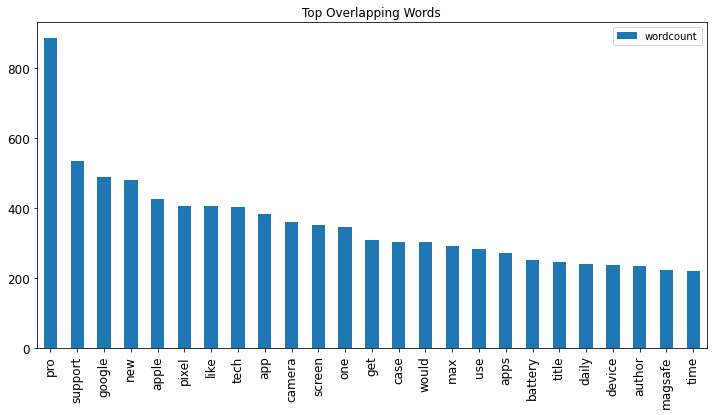

In [88]:
overlap_count.head(25).plot(kind = 'bar',
                      fontsize = 12, figsize = (12, 6), title = 'Top Overlapping Words')

**Overlapping Words**

Many observations can be made from this visualisation.  

Firstly, we see that Google and Apple appear as the top 5 words mentioned in both posts, suggesting that people on both subreddits are well aware that these are the two biggest names in the smartphone space. It also shows that people on both subreddits are aware of, and discuss the 'opposite camp' often.

Secondly, words like 'Pro', 'Support', 'Camera', 'Screen' etc shows that people posting on these subreddits are very tech-savvy. 

Features/names of both the iPhone and Android ecosystem are also mentioned here, such as [Pixel](https://store.google.com/sg/category/phones), Max[https://www.theverge.com/21555901/iphone-12-pro-max-review], and [Magsafe](https://www.pocket-lint.com/phones/news/apple/154269-what-is-magsafe-how-does-it-work-and-what-accessories-can-you-buy).

Next, we create a wordcloud of the overlapping words to give a more engaging visualisation of the data.

In [68]:
overlap_text = ''

for i in range(1471):
    
    word = str(overlap_count.index[i])
    
    for i in range(overlap_count['wordcount'][i]):
        
        overlap_text = overlap_text + word + ' '

In [69]:
len(overlap_text)

322907

In [70]:
overlap_text[:200]

'pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro pro '

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

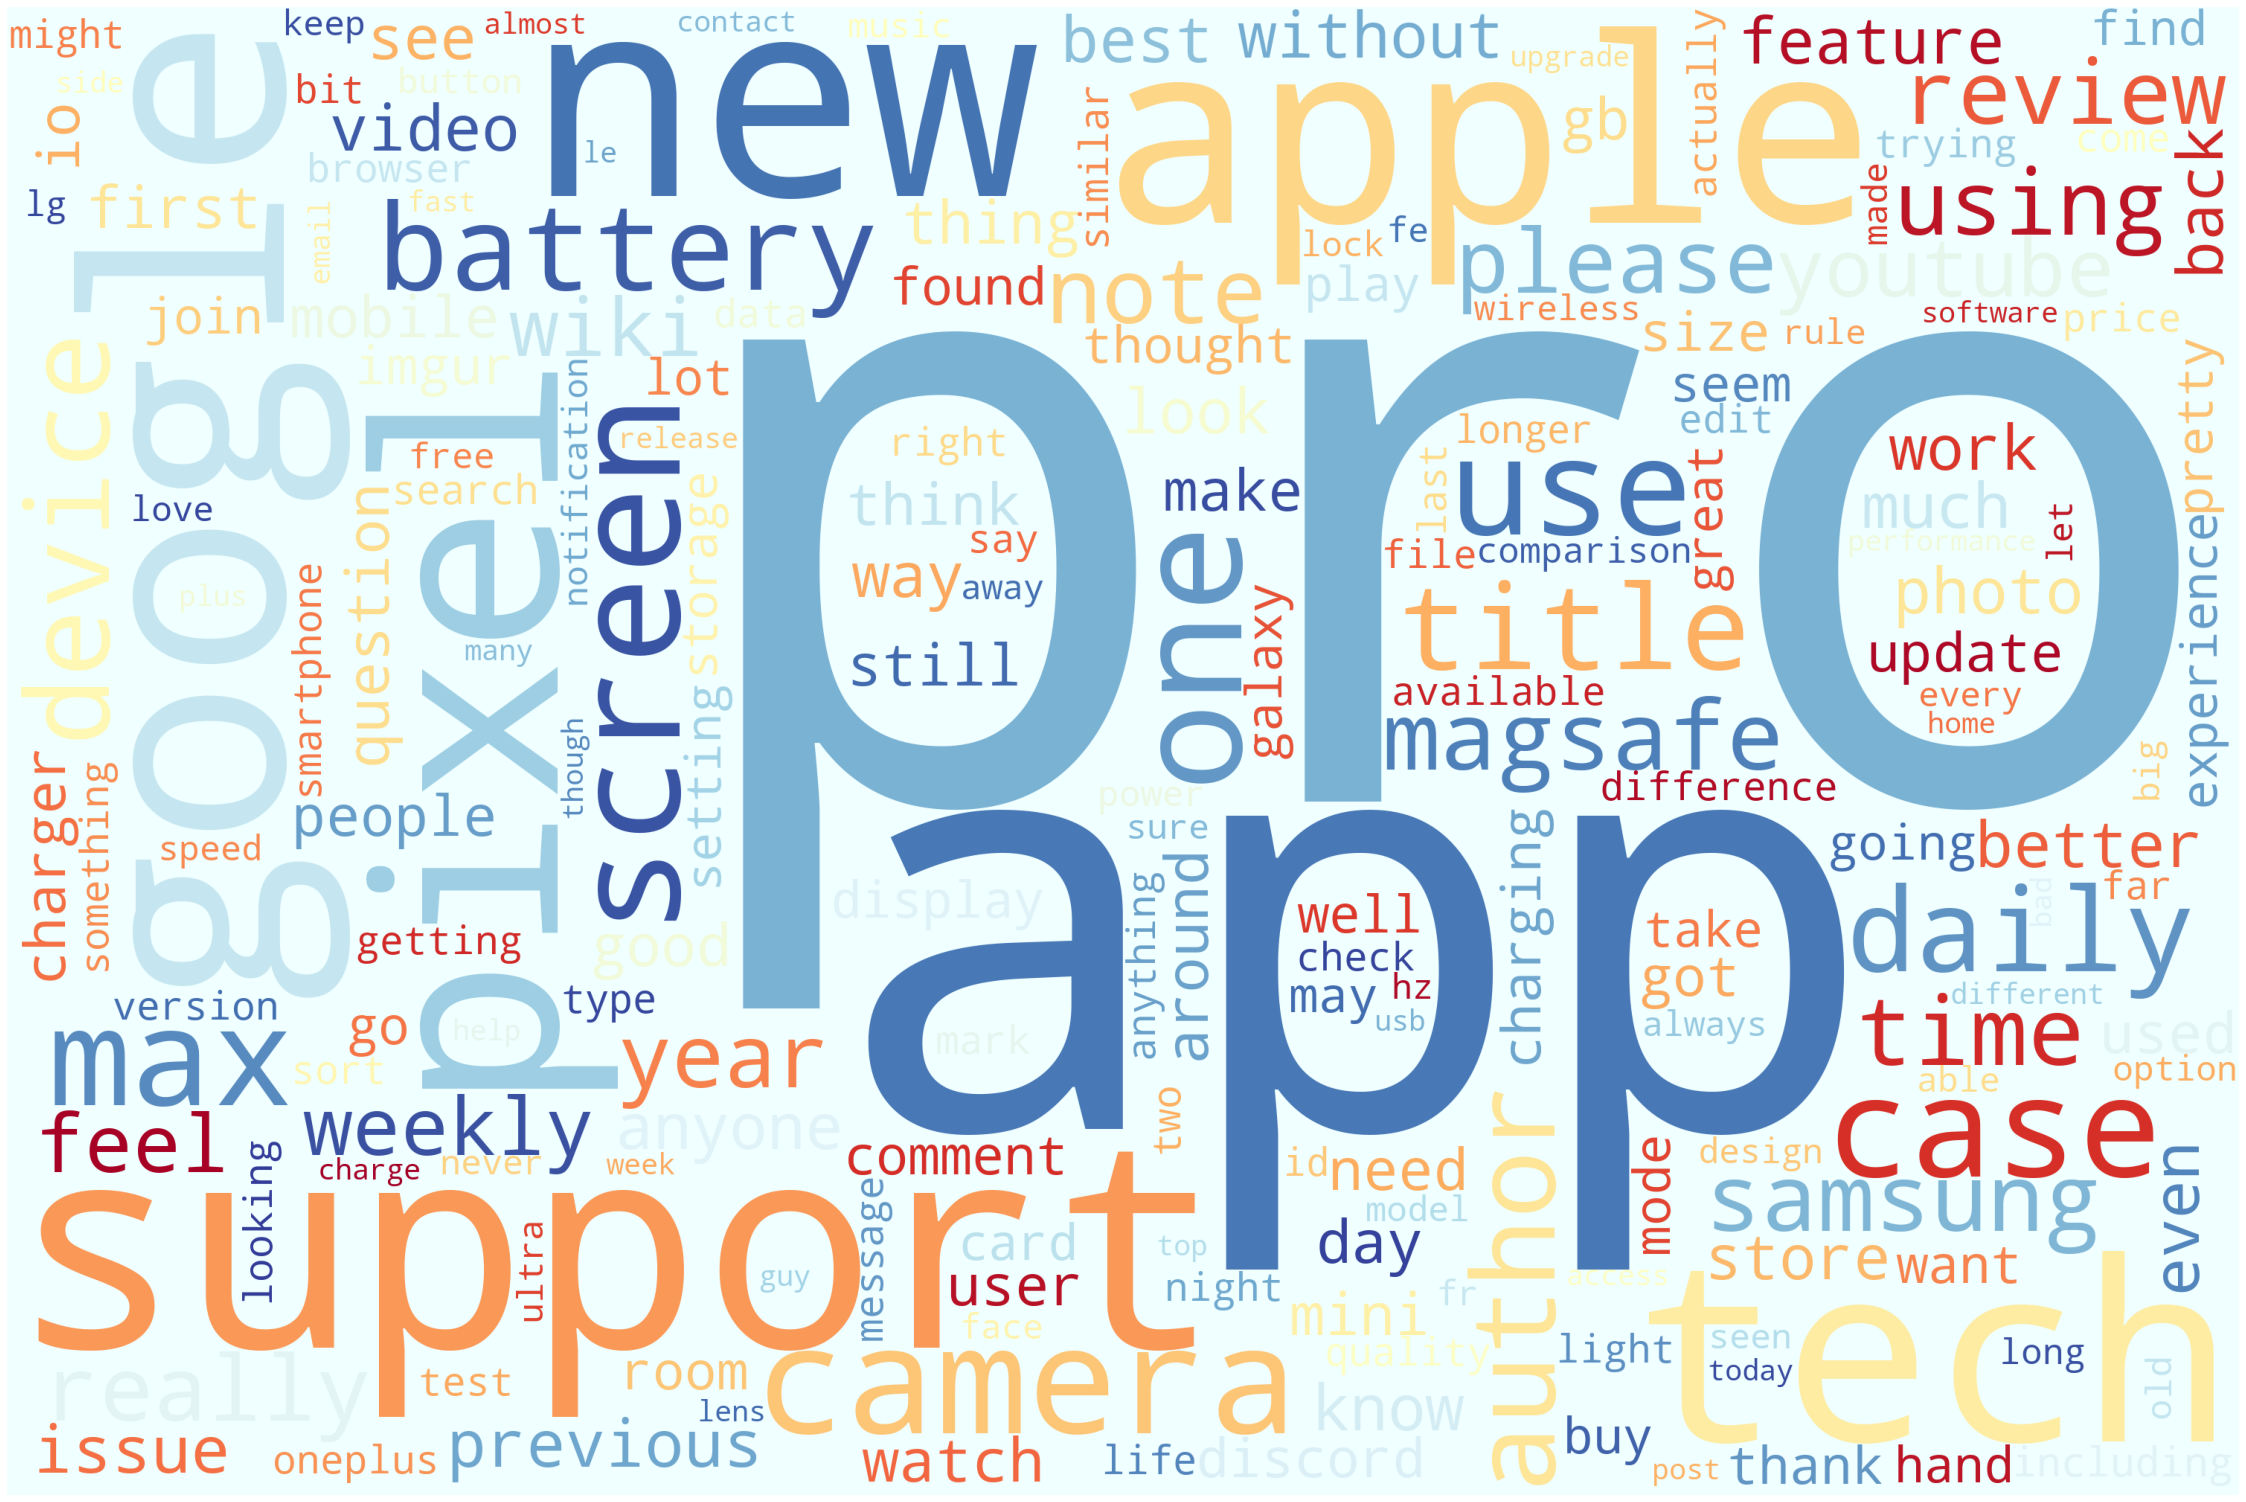

In [72]:
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='azure', colormap='RdYlBu', 
                      collocations=False).generate(overlap_text)
# Plot
plot_cloud(wordcloud)

**Visualisations for iPhone and Android subreddits**

We now want to look into the words appearing in the iPhone and Android subreddits respectively. These visualisations, together with the visualisations on overlapping words between the two subreddits, will prove very useful for analysis and interpretation later on.

In [73]:
iphone_df.head()

,aa,ability,able,aboard,absolute,absolutely,ac,accept,acceptable,access,...,yes,yesterday,yet,youtu,youtube,youtuber,yt,zm,zoom,zoomed
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
iphone_wordcount_df = iphone_df.sum(axis = 0).sort_values(ascending = False).to_frame(name = 'wordcount')
iphone_wordcount_df.head(20)

,wordcount
pro,726
support,479
apple,382
tech,375
new,323
max,275
case,251
title,243
author,231
daily,227


<AxesSubplot:title={'center':'Top iPhone Words'}>

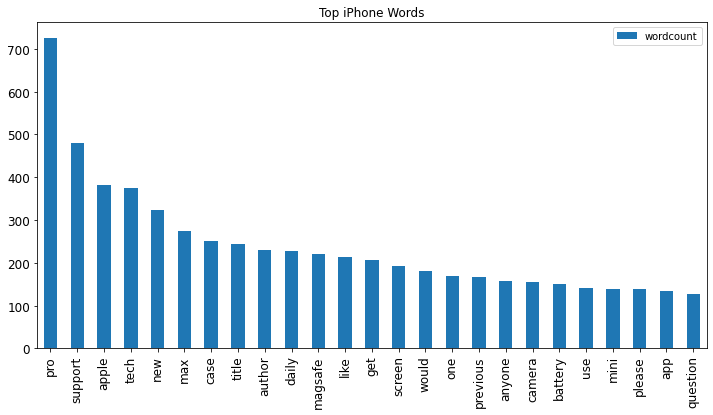

In [89]:
iphone_wordcount_df.head(25).plot(kind = 'bar',
                      fontsize = 12, figsize = (12, 6), title = 'Top iPhone Words')

In [76]:
iPhone_filtered.head(5)

,title/text,subreddit,cleaned_text
0,Welcome to the Daily Tech Support thread for ...,iphone,welcome daily tech support r question need ans...
1,I have hooked up a MagSafe charger in my car a...,iphone,hooked magsafe charger car connected third par...
2,Hi guys if I was to buy a iphone second hand ...,iphone,hi guy buy second hand brand new sealed condit...
3,Hello everyone I have the iPhone 11 and until...,iphone,hello everyone keeping io battery good everyth...
4,Proud owner of a new iPhone 11 Pro First tim...,iphone,proud owner new pro first time long time used ...


In [77]:
iPhone_filtered.shape

(943, 3)

In [78]:
iphone_text = iPhone_filtered['cleaned_text'].sum()

In [79]:
len(iphone_text)

224848

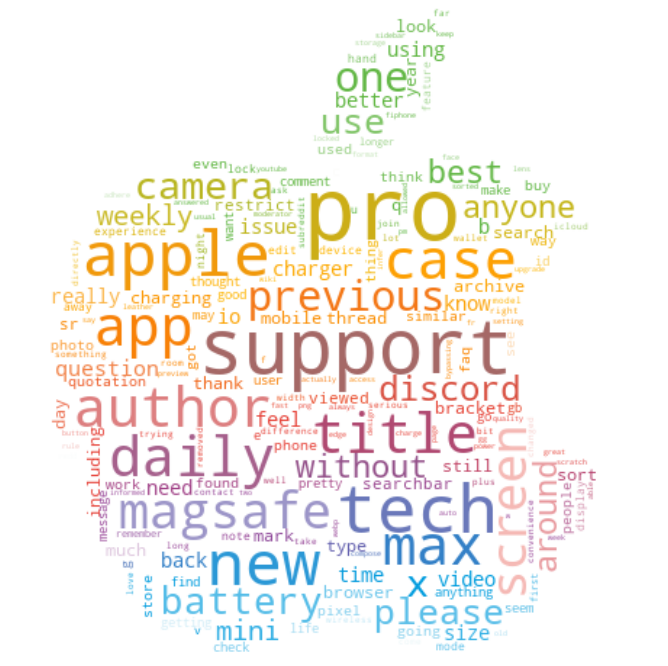

In [80]:
mask = np.array(Image.open('images/apple.jpg'))

image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(background_color="white", mask = mask, width = 2400, height = 2400,
                      random_state = 42, collocations = False, max_words = 200, max_font_size = 60)
                
wordcloud.generate(iphone_text)

plt.figure(figsize=[12,12])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

In [81]:
android_df.head()

,aa,aac,aayush,ability,able,absolute,absolutely,ac,accept,acceptable,...,youtu,youtube,youtubers,yr,yt,zenfone,zero,zifnab,zoom,zoomed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
android_wordcount_df = android_df.sum(axis = 0).sort_values(ascending = False).to_frame(name = 'wordcount')
android_wordcount_df.head(20)

,wordcount
google,449
pixel,329
app,247
samsung,207
camera,206
like,193
apps,182
device,180
one,176
pro,160


<AxesSubplot:title={'center':'Top Android Words'}>

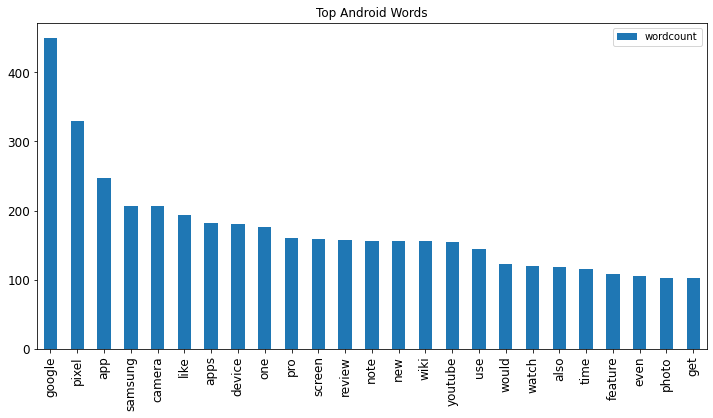

In [90]:
android_wordcount_df.head(25).plot(kind = 'bar',
                      fontsize = 12, figsize = (12, 6), title = 'Top Android Words')

In [84]:
Android_filtered.head()

,title/text,subreddit,cleaned_text
0,Samsung trade in program is back again for Bal...,Android,samsung trade program back baltic country good
1,Vivo unveils Origin Os Will it be less polar...,Android,vivo unveils origin o le polarizing previous one
2,Nokia 2 4 hands on GSMArena,Android,nokia hand gsmarena
3,Are high speed high capacity A1 A2 U3 micr...,Android,high speed high capacity u microsd card worth ...
4,Android App Bundles could have a drawback for ...,Android,app bundle could drawback developer power user


In [85]:
android_text = Android_filtered['cleaned_text'].sum()

In [86]:
len(android_text)

218890

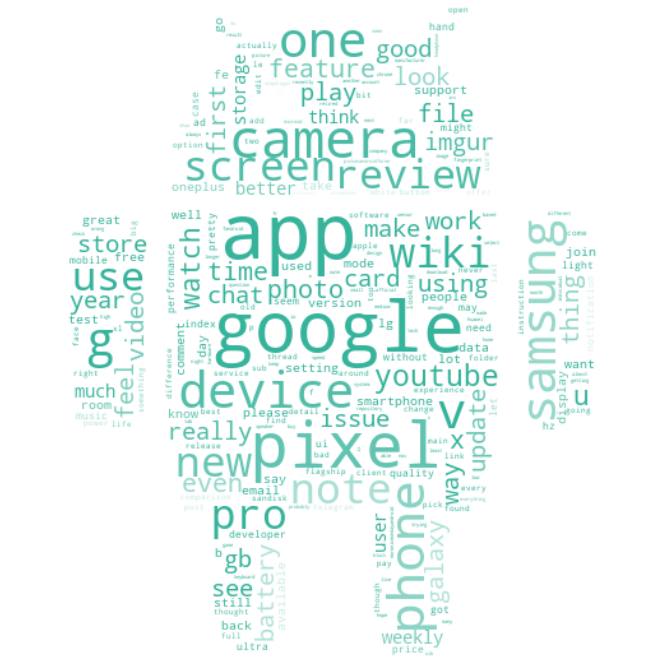

In [87]:
mask = np.array(Image.open('images/android2.jpg'))

image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(background_color="white", mask = mask, width = 2400, height = 2400,
                      random_state = 42, collocations = False, max_words = 250, max_font_size = 60)
                
wordcloud.generate(android_text)

plt.figure(figsize=[12,12])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()